In [511]:
import yfinance as yf
import numpy as np
import pyextremes as pyx
import matplotlib.pyplot as plt
import pandas as pd
from arch import arch_model
from statsmodels.stats.diagnostic import (acorr_ljungbox)
import statsmodels.api as sm
from pyextremes import EVA
from scipy.stats import chi2

In [628]:
ticker = "^GSPC"
spdata = yf.download(ticker, start="2013-12-17", end="2025-03-14", interval="1d")
sp_data = spdata['Close']
print(sp_data.head())

[*********************100%***********************]  1 of 1 completed

Ticker            ^GSPC
Date                   
2013-12-17  1781.000000
2013-12-18  1810.650024
2013-12-19  1809.599976
2013-12-20  1818.319946
2013-12-23  1827.989990


In [629]:
sp_data1 = sp_data.reset_index("Date").set_index("Date")["^GSPC"]
print(sp_data1.head())

Date
2013-12-17    1781.000000
2013-12-18    1810.650024
2013-12-19    1809.599976
2013-12-20    1818.319946
2013-12-23    1827.989990
Name: ^GSPC, dtype: float64


In [630]:
log_returns_sp0 = np.log(sp_data1 / sp_data1.shift(1)).dropna()
log_returns_sp = log_returns_sp0[:len(log_returns_sp0)//2]
test_log = log_returns_sp0[len(log_returns_sp0)//2+1:]

In [631]:
print(test_log.head())

Date
2019-08-01   -0.009040
2019-08-02   -0.007309
2019-08-05   -0.030230
2019-08-06    0.012933
2019-08-07    0.000767
Name: ^GSPC, dtype: float64


Text(0, 0.5, 'Price (USD)')

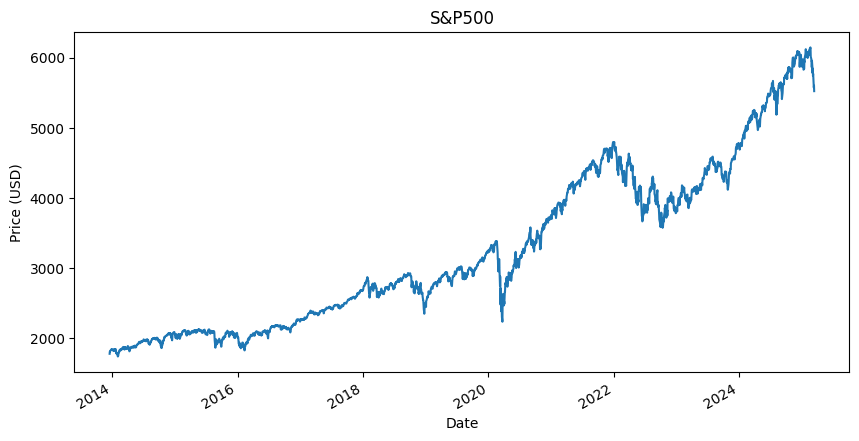

In [747]:
sp_data1.plot(title='S&P500', figsize=(10, 5))
plt.xlabel('Date')
plt.ylabel('Price (USD)')

Text(0, 0.5, 'Price (USD)')

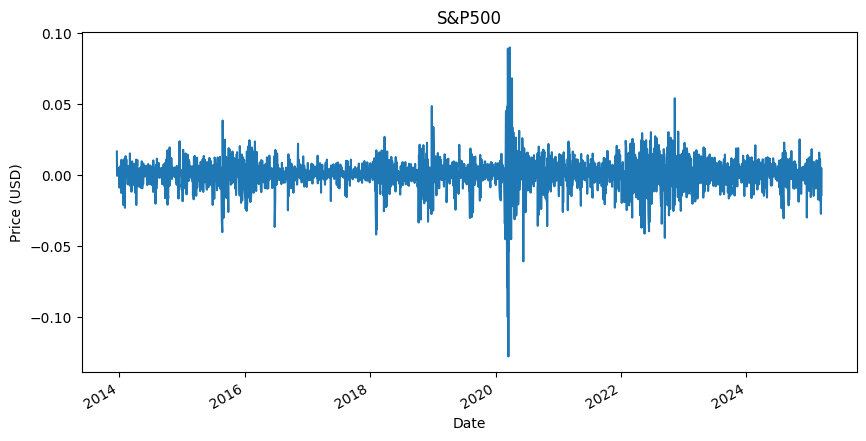

In [658]:
log_returns_sp0.plot(title='S&P500', figsize=(10, 5))
plt.xlabel('Date')
plt.ylabel('Price (USD)')

In [723]:
# functions
def hill_estimator(data, k):
    log_data = np.log(data[:k])
    return (1/k) * np.sum(log_data) - np.log(data[k])

def pickands_estimator(data, k):
    if 4*k >= len(data):
        return np.nan
    return 1/np.log(2) * np.log((data[k] - data[2*k])/(data[2*k] - data[4*k]))

def threshold_picking(data0):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    data = -data0[data0 < 0]
    thresholds = np.linspace(data.quantile(0.2), data.quantile(0.995), 200)
    pyx.plot_mean_residual_life(data, thresholds=thresholds, ax=axs[0])
    axs[0].set_title("Mean Residual Life")

    datas = np.sort(data)[::-1]
    k_values = range(4, int(len(datas)/1.3))

    hill_estimates = [hill_estimator(datas, k) for k in k_values]
    axs[1].plot(k_values, hill_estimates, 'b-')
    axs[1].set_xlabel("k_values")
    axs[1].set_ylabel("hill estimates")
    axs[1].set_title("Hill Plot")

    pickands_estimates = [pickands_estimator(datas, k) for k in k_values]
    axs[2].plot(k_values, pickands_estimates, 'r-', label="Pickands' ξ")
    axs[2].set_xlabel("k_values")
    axs[2].set_ylabel("pickands' estimates")
    axs[2].set_title("Pickands Plot")
    plt.tight_layout()
    plt.show()
    pyx.plot_threshold_stability(-data0, return_period=10)
    plt.title("Parameter stability plot")
    plt.show()
    return datas

def modeling(data0, u):
    data = -data0[data0 < 0]
    model = EVA(data)
    model.get_extremes(method="POT", threshold=u)
    model.fit_model(distribution="genpareto")
    print(model.model)
    model.plot_diagnostic()

    params = model.model.fit_parameters
    print(params)
    xi = params['c']
    sig = params['scale']
    return xi, sig

def prediction(params, data, u, level):
    xi = params[0]
    sig = params[1]
    data = -data
    p = level
    n_total = len(data)
    n_exceed = len([i for i in data if i > u])
    F_u = n_exceed / n_total
    p_u = F_u / p
    VaR = u + (sig / xi) * (p_u ** xi - 1)
    ES = ES = (VaR + (sig - xi * u)) / (1 - xi)
    return -VaR, -ES


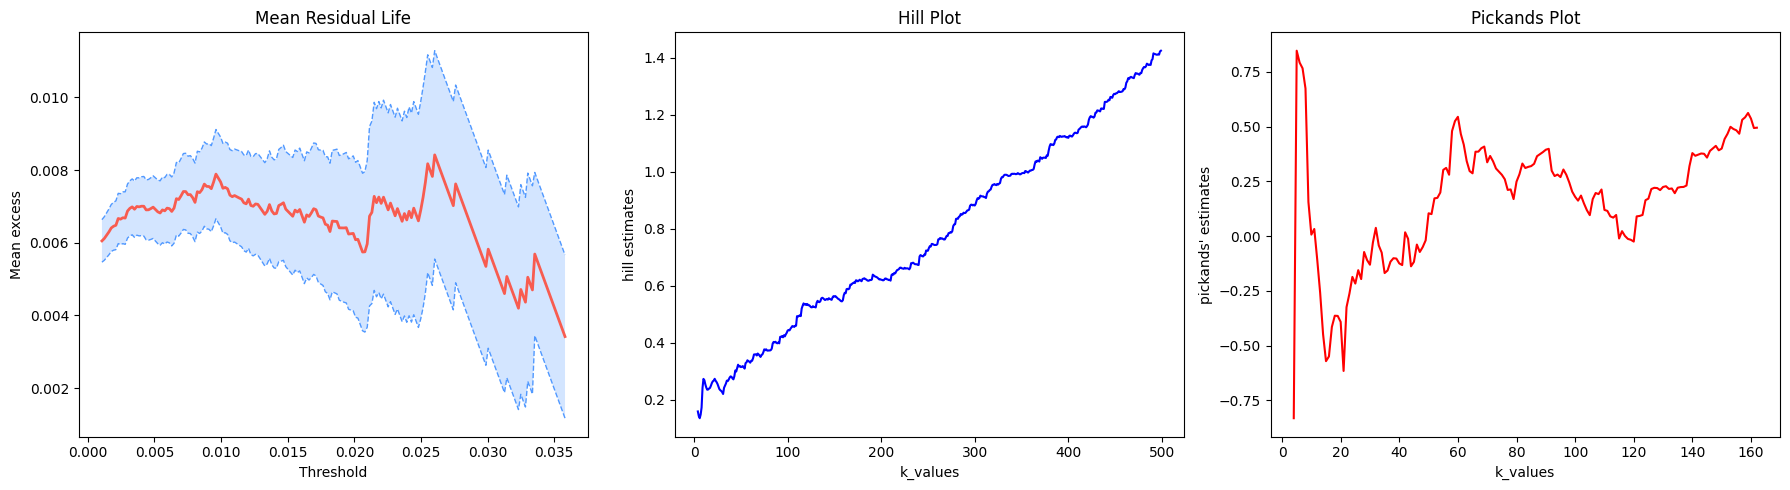

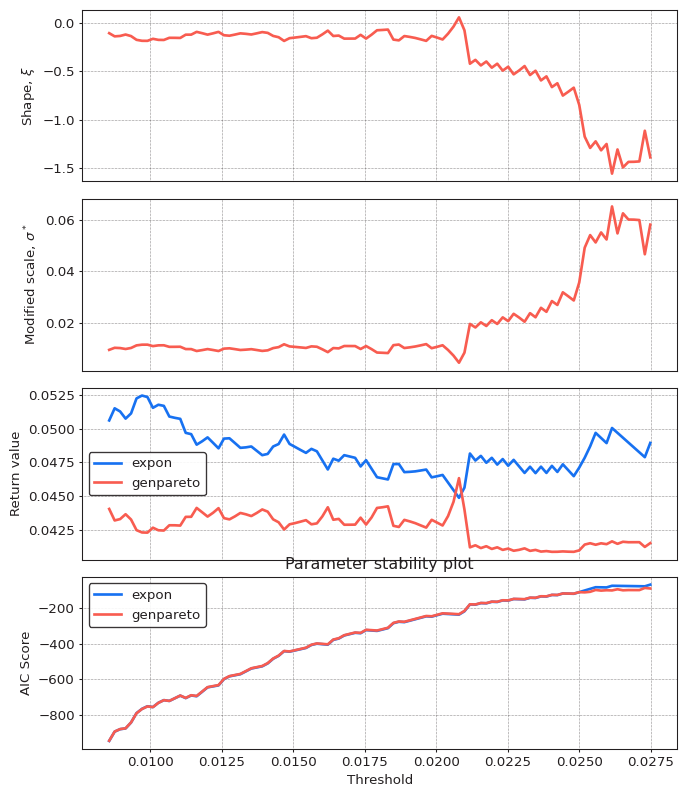

In [724]:
sorted_static_sp = threshold_picking(log_returns_sp)

In [725]:
u_static_sp = sorted_static_sp[130]
print(u_static_sp)

0.009217532410166119


              MLE model               
--------------------------------------
free parameters: c=-0.119, scale=0.009
fixed parameters: floc=0.009          
AIC: -867.478                         
loglikelihood: 435.794                
return value cache size: 0            
fit parameter cache size: 0           
--------------------------------------
{'c': np.float64(-0.11926199303629778), 'scale': np.float64(0.008762040481931835)}
(np.float64(-0.11926199303629778), np.float64(0.008762040481931835))


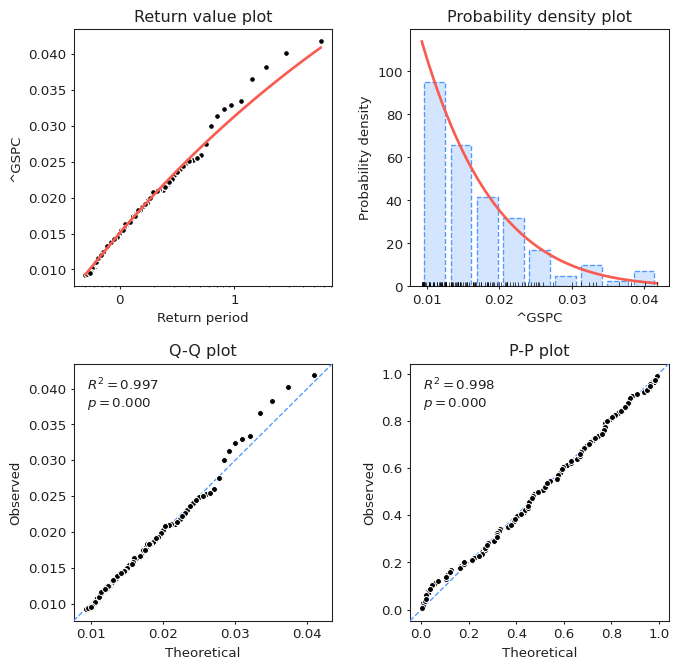

In [726]:
params3 = modeling(log_returns_sp, u_static_sp)
print(params3)

In [641]:
VaR_sb, ES_sb = prediction(params3, log_returns_sp, u_static_sp, 0.01)
print(VaR_sb, ES_sb)

-0.025778210761206663 -0.03327728276107051


/Users/workman/Desktop/pypro/T02_venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.813e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 103234111894.03018
Iteration:      2,   Func. Count:     19,   Neg. LLF: 10442585229.354424
Iteration:      3,   Func. Count:     31,   Neg. LLF: -4957.444899079576
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4957.444899674854
            Iterations: 7
            Function evaluations: 31
            Gradient evaluations: 3
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                4957.44
Distribution:                  Normal   AIC:                          -9906.89
Method:            Maximum Likelihood   BIC:                          -9885.88
                                        No. Observations:                 1412
Date:               

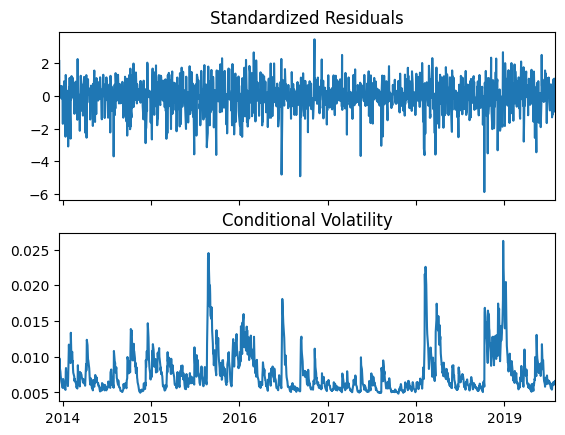

    lb_stat  lb_pvalue
1  0.663506   0.415325
2  0.685570   0.709791
3  1.427216   0.699168
4  1.761455   0.779526
5  4.475251   0.483202
Ljung-Box test on squared residuals:
    lb_stat  lb_pvalue
1  0.724110   0.394799
2  0.724215   0.696208
3  0.795484   0.850547
4  3.805850   0.432918
5  5.190350   0.393094


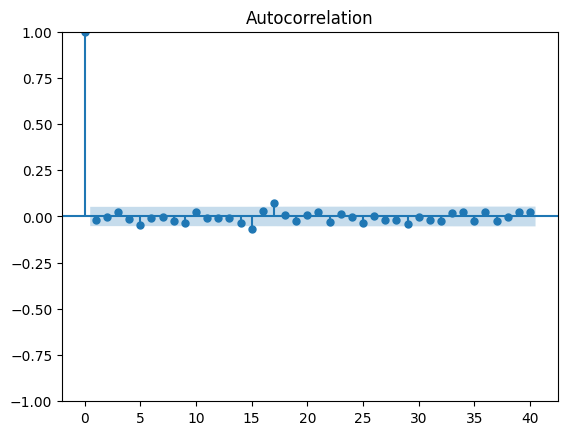

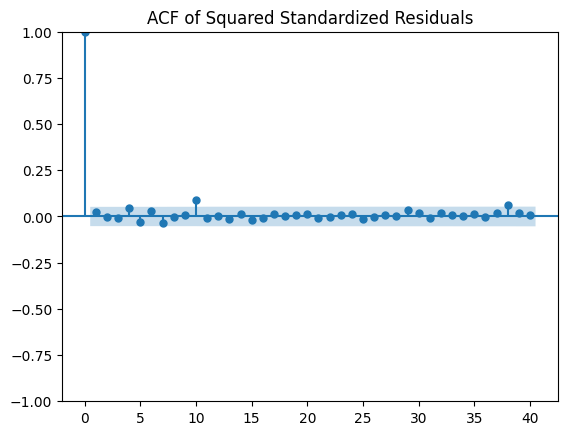

In [738]:
model3 = arch_model(log_returns_sp, vol='Garch', p=1, q=1)
results2 = model3.fit()
print(results2.summary())
results2.plot()
plt.show()
standardized_resid2 = results2.resid / results2.conditional_volatility
sigma_train = results2.conditional_volatility

ljung_box = acorr_ljungbox(standardized_resid2, lags=5, return_df=True)
print(ljung_box)

squared_resid2 = standardized_resid2**2
lb_test_squared2 = acorr_ljungbox(squared_resid2, lags=5, return_df=True)
print("Ljung-Box test on squared residuals:")
print(lb_test_squared2)
sm.graphics.tsa.plot_acf(standardized_resid2.dropna(), lags=40)
sm.graphics.tsa.plot_acf(squared_resid2.dropna(), lags=40)
plt.title('ACF of Squared Standardized Residuals')
plt.show()

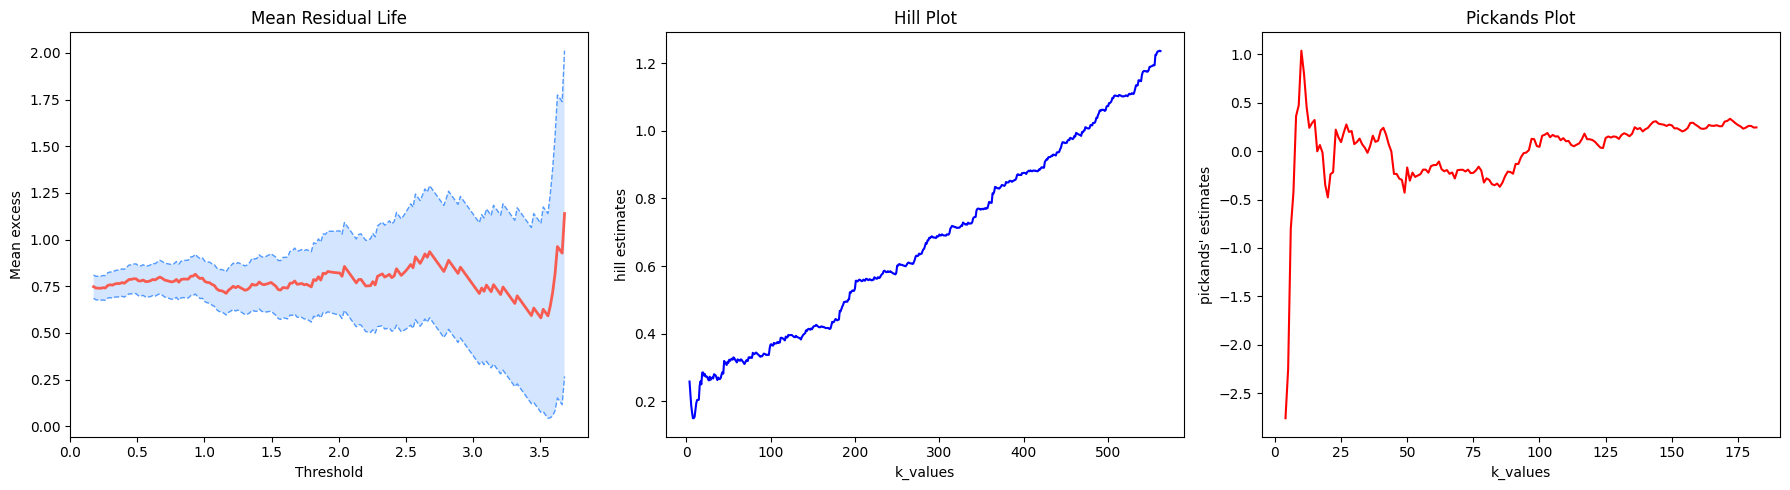

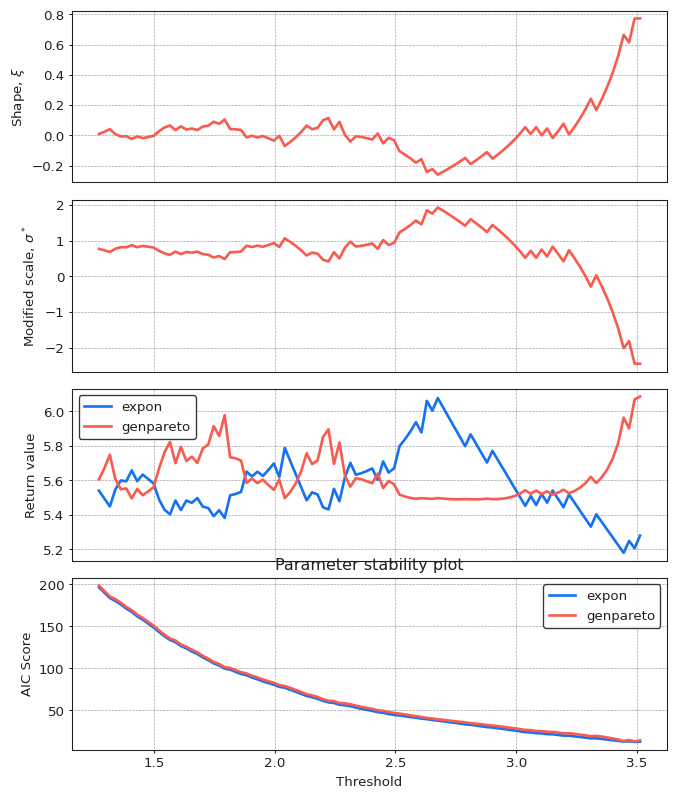

In [748]:
sorted_d_sp = threshold_picking(standardized_resid2.dropna())

In [741]:
u_d_sp = sorted_d_sp[150]
print(u_d_sp)

1.2224984899549753


              MLE model              
-------------------------------------
free parameters: c=0.006, scale=0.783
fixed parameters: floc=1.222         
AIC: 211.195                         
loglikelihood: -103.553              
return value cache size: 0           
fit parameter cache size: 0          
-------------------------------------
{'c': np.float64(0.006309874968631076), 'scale': np.float64(0.782822296057696)}
(np.float64(0.006309874968631076), np.float64(0.782822296057696))


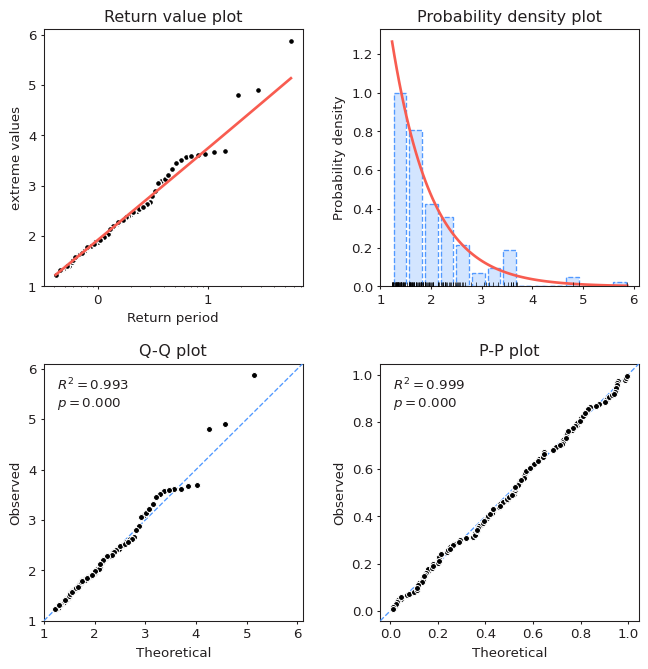

In [742]:
params4 = modeling(standardized_resid2, u_d_sp)
print(params4)

In [755]:
VaR_db, ES_db = prediction(params4, standardized_resid2, u_d_sp, 0.01)
print(VaR_db, ES_db)

-3.086201131852028 -3.885828708589485


In [756]:
def conditional_coverage_test(actual_returns, var_forecast, alpha=0.01):
    # Unconditional Coverage (UC) Test
    actual_returns = np.asarray(actual_returns).flatten()
    var_forecast = np.asarray(var_forecast).flatten()
    
    min_length = min(len(actual_returns), len(var_forecast))
    actual_returns = actual_returns[:min_length]
    var_forecast = var_forecast[:min_length]
    violations = (actual_returns < var_forecast).astype(int) 
    #print(violations.head())
    n = len(violations)
    V = np.sum(violations)
    p_uc = V / n
    #print(actual_returns.head(), var_forecast, p_uc)
    ll_null = V * np.log(alpha) + (n - V) * np.log(1 - alpha)
    ll_alt = V * np.log(p_uc) + (n - V) * np.log(1 - p_uc)
    LR_uc = -2 * (ll_null - ll_alt)
    p_value_uc = 1 - chi2.cdf(LR_uc, df=1)
    
    # Independence (IND) Test
    # Count transitions: n_ij = transitions from state i to j (0=no violation, 1=violation)
    n00, n01, n10, n11 = 0, 0, 0, 0
    for t in range(1, n):
        prev, curr = violations[t-1], violations[t]
        if prev == 0 and curr == 0: n00 += 1
        elif prev == 0 and curr == 1: n01 += 1
        elif prev == 1 and curr == 0: n10 += 1
        elif prev == 1 and curr == 1: n11 += 1
    
    # Transition probabilities under H0 (independence)
    p01 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
    p11 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0
    p_ind = (n01 + n11) / (n00 + n01 + n10 + n11)  # Marginal violation probability
    
    # Likelihoods
    L_ind = (1 - p_ind)**(n00 + n10) * p_ind**(n01 + n11)  # Independence
    L_actual = (1 - p01)**n00 * p01**n01 * (1 - p11)**n10 * p11**n11  # Observed
    
    LR_ind = -2 * np.log(L_ind / L_actual) if L_actual > 0 else 0
    p_value_ind = 1 - chi2.cdf(LR_ind, df=1)
    
    # Conditional Coverage (CC) Test
    LR_cc = LR_uc + LR_ind
    p_value_cc = 1 - chi2.cdf(LR_cc, df=2)
    
    # Decisions
    reject_uc = p_value_uc < 0.05
    reject_ind = p_value_ind < 0.05
    reject_cc = p_value_cc < 0.05
    
    return {
        "LR_UC": LR_uc,
        "p-value_UC": p_value_uc,
        "Reject_UC?": reject_uc,
        "LR_IND": LR_ind,
        "p-value_IND": p_value_ind,
        "Reject_IND?": reject_ind,
        "LR_CC": LR_cc,
        "p-value_CC": p_value_cc,
        "Reject_CC?": reject_cc,
        "Violation Rate": V / n,
        "Expected Rate": alpha,
        "Transition Matrix": [[n00, n01], [n10, n11]],
    }

In [759]:
X_train = log_returns_sp
VaR_sb_s_train = np.repeat(VaR_sb, len(X_train))
VaR_db_train = VaR_db * results2.conditional_volatility
print(conditional_coverage_test(X_train, VaR_sb_s_train))
print(conditional_coverage_test(X_train, VaR_db_train))

{'LR_UC': np.float64(0.7536254089056627), 'p-value_UC': np.float64(0.38533082672847285), 'Reject_UC?': np.False_, 'LR_IND': np.float64(3.242269093285041), 'p-value_IND': np.float64(0.07176118691624711), 'Reject_IND?': np.False_, 'LR_CC': np.float64(3.9958945021907035), 'p-value_CC': np.float64(0.1356133779226656), 'Reject_CC?': np.False_, 'Violation Rate': np.float64(0.007790368271954674), 'Expected Rate': 0.01, 'Transition Matrix': [[1390, 10], [10, 1]]}
{'LR_UC': np.float64(0.09218237960260467), 'p-value_UC': np.float64(0.7614208316833906), 'Reject_UC?': np.False_, 'LR_IND': np.float64(2.607562734364421), 'p-value_IND': np.float64(0.10635510687645033), 'Reject_IND?': np.False_, 'LR_CC': np.float64(2.6997451139670257), 'p-value_CC': np.float64(0.2592733011120467), 'Reject_CC?': np.False_, 'Violation Rate': np.float64(0.009206798866855524), 'Expected Rate': 0.01, 'Transition Matrix': [[1386, 12], [12, 1]]}


In [745]:
sigma_test = [sigma_train.iloc[-1]]
VaR = []
omega, alpha, beta_garch = results2.params[["omega", "alpha[1]", "beta[1]"]]
for x_t in test_log[:-1]:
    sigma_t = sigma_test[-1]
    sigma_t1 = np.sqrt(omega + alpha * x_t**2 + beta_garch * sigma_t**2)
    sigma_test.append(sigma_t1)

    var_t1 = sigma_t1 * VaR_db
    VaR.append(var_t1)

X_test = test_log[1:]
VaR_sb_s = np.repeat(VaR_sb, len(VaR))
print(VaR_sb_s[300], VaR[201])

-0.025778210761206663 -0.046858895286997146


In [746]:
print(conditional_coverage_test(X_test, VaR_sb_s))
print(conditional_coverage_test(X_test, VaR))

{'LR_UC': np.float64(34.209424403477044), 'p-value_UC': np.float64(4.948870424570373e-09), 'Reject_UC?': np.True_, 'LR_IND': np.float64(4.480032182186201), 'p-value_IND': np.float64(0.03429307528905956), 'Reject_IND?': np.True_, 'LR_CC': np.float64(38.689456585663244), 'p-value_CC': np.float64(3.969092721156642e-09), 'Reject_CC?': np.True_, 'Violation Rate': np.float64(0.029057406094968107), 'Expected Rate': 0.01, 'Transition Matrix': [[1332, 37], [37, 4]]}
{'LR_UC': np.float64(0.09058717877979916), 'p-value_UC': np.float64(0.7634320024315007), 'Reject_UC?': np.False_, 'LR_IND': np.float64(0.24195052137866926), 'p-value_IND': np.float64(0.6228008812895243), 'Reject_IND?': np.False_, 'LR_CC': np.float64(0.3325377001584684), 'p-value_CC': np.float64(0.8468185363518851), 'Reject_CC?': np.False_, 'Violation Rate': np.float64(0.009213323883770375), 'Expected Rate': 0.01, 'Transition Matrix': [[1384, 13], [13, 0]]}
